<a href="https://colab.research.google.com/github/DommiiUdomp/Prediction/blob/main/House_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

import statsmodels.api as sm
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import warnings 
warnings.filterwarnings ("ignore")

import plotly.graph_objects as go
import sklearn.feature_selection as fs
import sklearn.linear_model as lm

# **Data Exploration**

In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df = df.drop(columns=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])
    
    df_cat = df.loc[:,df.dtypes==np.object]
    df_num = df.select_dtypes(include='number')

    df_numerical = df_num.fillna(df_num.mean())
    df_categorical = df_cat.fillna(df_cat.mode().iloc[0])
    # deleting categorical columns with more than 7 unique categories
    df_categorical.drop(columns=['Neighborhood','Condition1','Condition2','HouseStyle','RoofMatl','Exterior1st','Exterior2nd',
                            'BsmtFinType1','BsmtFinType2','Functional','GarageType','SaleType'], inplace=True)
    
    ord_enc = OrdinalEncoder()

    encoded = []
    for i in df_categorical.columns:
        df_categorical[i] = ord_enc.fit_transform(df_categorical[[i]])
        encoded.append(df_categorical)

    df_categorical_encoded = encoded[25]
    df_categorical_encoded
    
    HouseP_test_df = df_categorical_encoded.join(df_numerical)
    
    return HouseP_test_df

In [ ]:
def forward_stepwise(X, y,threshold_in, verbose=False):
    a_list = []
    # creating a variable included that will have a list of a_list variable 
    included = list(a_list)
    # Using while loop to set a condition for selecting best features into included and worst features into excluded variables
    while True:
        # creating a variable excluded that will take the columns name excluding the ones from included variable
        excluded = list(set(X.columns)-set(included)) 
        # creating a new variable new_pval that holds all the pvalues of the excluded columns
        new_pval = pd.Series(index=excluded)
#         print('The remaining independent variables in our dataset are:')   # displaying this message
#         print(excluded)     # printing or displaying all the columns in excluded list
#         print(' ')       # displaying empty space
        changed=False      # set the condition at this stage
        
        for new_column in excluded:           # use for loop to iterate through each variable
            ## use stepwise to fit the model 
            final_model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            
            ## extracting pvalues from the model
            new_pval[new_column] = final_model.pvalues[new_column]
            
        ## best-pval are the minimum p-values from the list of p-values obtained above in new-pval
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            performed_variables = new_pval.idxmin()
            included.append(performed_variables)
            changed=True
            
            ## this will give us the most features using stepwise regression method i.e it will Add best features as performed variables and print it out            
            if verbose:
#                 print('now add this variable to the best performing features')
                print('Add  {:30} with p-value {:.6}'.format(performed_variables, best_pval))
#                 print(' ')
#                 print('The best performing features are:')
#                 print(included)
#                 print(' ')
        if not changed:
            break
    ## this will return the included list of features with p-values that are less than threshold-in and summary statistics of the model
    return included

In [ ]:
df_train = wrangle('/content/train.csv')
X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

X_test = wrangle('/content/test.csv')
y_test_target = pd.read_csv('sample_submission.csv')
y_test = y_test_target['SalePrice']

In [ ]:
best_features = forward_stepwise(X_train, y_train, 0.05, verbose = True)
print(best_features)

# Training data
X_train = X_train[best_features]

# Testing data
X_test = X_test[best_features]

Add  OverallQual                    with p-value 2.18568e-313
Add  GrLivArea                      with p-value 1.87051e-87
Add  BsmtFinSF1                     with p-value 3.42354e-39
Add  BsmtQual                       with p-value 6.32269e-33
Add  MSSubClass                     with p-value 5.65479e-23
Add  GarageCars                     with p-value 2.728e-18
Add  KitchenQual                    with p-value 5.15133e-20
Add  BsmtExposure                   with p-value 1.33768e-09
Add  ExterQual                      with p-value 8.34399e-08
Add  LotArea                        with p-value 4.58998e-07
Add  OverallCond                    with p-value 1.70485e-06
Add  YearBuilt                      with p-value 2.11778e-10
Add  MasVnrArea                     with p-value 2.72519e-06
Add  Fireplaces                     with p-value 1.55794e-05
Add  BsmtFullBath                   with p-value 0.000654671
Add  LotFrontage                    with p-value 0.000944266
Add  MasVnrType          

In [ ]:
y_test_target.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1460, 22) (1460,) (1459, 22) (1459,)


In [ ]:
train_features = df_train.copy()
test_features = X_test.copy()

train_labels = train_features.pop('SalePrice')
test_labels = y_test_target.pop('SalePrice')

In [ ]:
test_features.describe().transpose()[['mean', 'std']]

,mean,std
OverallQual,6.078821,1.436812
GrLivArea,1486.045922,485.566099
BsmtFinSF1,439.203704,455.111888
BsmtQual,2.240576,0.905159
MSSubClass,57.378341,42.746880
GarageCars,1.766118,0.775679
KitchenQual,2.354352,0.838789
BsmtExposure,2.314599,1.105107
ExterQual,2.521590,0.710527
LotArea,9819.161069,4955.517327


In [ ]:
def normalize(X):
    """Normalize features between 0 and 1"""
    
    if len(X.shape) == 1:
        dummy = pd.Series(np.empty(len(X)), name='dummy')
        #dummy.index = y.index
        X = pd.concat([X, dummy], axis=1)
        X[:] = MinMaxScaler().fit_transform(X)
        X = X.drop('dummy', axis=1)
    else:
        X[:] = MinMaxScaler().fit_transform(X)
    
    return X

X = normalize(X_train)
X.head()

,OverallQual,GrLivArea,BsmtFinSF1,BsmtQual,MSSubClass,GarageCars,KitchenQual,BsmtExposure,ExterQual,LotArea,...,MasVnrArea,Fireplaces,BsmtFullBath,LotFrontage,MasVnrType,ScreenPorch,SaleCondition,WoodDeckSF,LandContour,Street
0,0.666667,0.259231,0.125089,0.666667,0.235294,0.50,0.666667,1.000000,0.666667,0.033420,...,0.12250,0.000000,0.333333,0.150685,0.333333,0.0,0.8,0.000000,1.0,1.0
1,0.555556,0.174830,0.173281,0.666667,0.000000,0.50,1.000000,0.333333,1.000000,0.038795,...,0.00000,0.333333,0.000000,0.202055,0.666667,0.0,0.8,0.347725,1.0,1.0
2,0.666667,0.273549,0.086109,0.666667,0.235294,0.50,0.666667,0.666667,0.666667,0.046507,...,0.10125,0.333333,0.333333,0.160959,0.333333,0.0,0.8,0.000000,1.0,1.0
3,0.666667,0.260550,0.038271,1.000000,0.294118,0.75,0.666667,1.000000,1.000000,0.038561,...,0.00000,0.333333,0.333333,0.133562,0.666667,0.0,0.0,0.000000,1.0,1.0
4,0.777778,0.351168,0.116052,0.666667,0.235294,0.75,0.666667,0.000000,0.666667,0.060576,...,0.21875,0.333333,0.333333,0.215753,0.333333,0.0,0.8,0.224037,1.0,1.0


['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'MasVnrArea', 'Fireplaces']


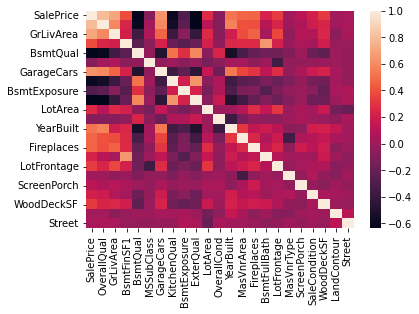

In [ ]:
corr_mat = pd.concat([normalize(y_train), X], axis=1).corr()
continuous_features_corr = list(corr_mat[corr_mat < 1][corr_mat > 0.4]['SalePrice'].dropna().index)
print(continuous_features_corr)
sns.heatmap(corr_mat)

In [ ]:
def plot_actual_vs_pred(model, X, y):
    """Plotting actual vs predicted label"""
    
    y_pred = model.predict(X)
    
    plot_data = pd.concat([y, pd.Series(y_pred, name='PredictedPrice', index=y.index)], axis=1)
    plot_data = plot_data.sort_values('SalePrice')
    plot_data.index = y.index
    plot_data = plot_data.reset_index()
    
    fig = px.scatter(plot_data, x='index', y='SalePrice')
    fig.add_trace(go.Scatter(x=plot_data['index'], y=plot_data['PredictedPrice'], name='Prediction'))
    fig.show()

In [ ]:
model = DecisionTreeRegressor()
model.fit(X, y_train)
print('score =', model.score(X, y_train))
print('score =', cross_val_score(model, X, y_train))

plot_actual_vs_pred(model, X, y_train)

score = 0.9999960565847476
score = [0.65216231 0.78936254 0.75589202 0.46682373 0.69231472]


In [ ]:
test_preds = pd.DataFrame.from_dict({'SalePrice': (model.predict(X_test))})
test_preds.head()

,SalePrice
0,144000.0
1,150000.0
2,197500.0
3,223000.0
4,212000.0


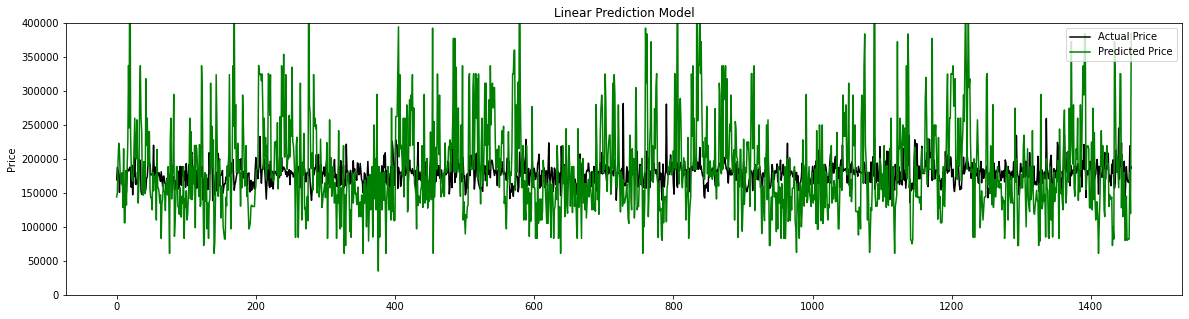

In [ ]:
def plot(actual, predict, name):
  plt.figure(figsize=(20,5))
  plt.plot(actual,color='black',label='Actual Price')
  plt.plot(predict,color='green',label='Predicted Price')
  plt.title(f'{name}')
  plt.ylabel('Price')
  plt.ylim((0,400000))
  plt.legend(loc='upper right')
  plt.show()

plot(y_test, test_preds['SalePrice'], 'Linear Prediction Model')

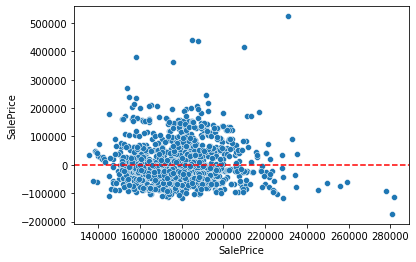

In [ ]:
residuals = model.predict(X_test) - y_test
sns.scatterplot(x=y_test,y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

In [ ]:
model.get_depth()

23

# **Tensorflow**

In [ ]:
!pip install tensorflow_decision_forests

In [3]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import collections

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import warnings 
warnings.filterwarnings ("ignore")

import plotly.graph_objects as go
import sklearn.feature_selection as fs
import sklearn.linear_model as lm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
def forward_stepwise(X, y,threshold_in, verbose=False):
    a_list = []
    # creating a variable included that will have a list of a_list variable 
    included = list(a_list)
    # Using while loop to set a condition for selecting best features into included and worst features into excluded variables
    while True:
        # creating a variable excluded that will take the columns name excluding the ones from included variable
        excluded = list(set(X.columns)-set(included)) 
        # creating a new variable new_pval that holds all the pvalues of the excluded columns
        new_pval = pd.Series(index=excluded)
#         print('The remaining independent variables in our dataset are:')   # displaying this message
#         print(excluded)     # printing or displaying all the columns in excluded list
#         print(' ')       # displaying empty space
        changed=False      # set the condition at this stage
        
        for new_column in excluded:           # use for loop to iterate through each variable
            ## use stepwise to fit the model 
            final_model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            
            ## extracting pvalues from the model
            new_pval[new_column] = final_model.pvalues[new_column]
            
        ## best-pval are the minimum p-values from the list of p-values obtained above in new-pval
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            performed_variables = new_pval.idxmin()
            included.append(performed_variables)
            changed=True
            
            ## this will give us the most features using stepwise regression method i.e it will Add best features as performed variables and print it out            
            if verbose:
#                 print('now add this variable to the best performing features')
                print('Add  {:30} with p-value {:.6}'.format(performed_variables, best_pval))
#                 print(' ')
#                 print('The best performing features are:')
#                 print(included)
#                 print(' ')
        if not changed:
            break
    ## this will return the included list of features with p-values that are less than threshold-in and summary statistics of the model
    return included


In [18]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df = df.drop(columns=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])
    
    df_cat = df.loc[:,df.dtypes==np.object]
    df_num = df.select_dtypes(include='number')

    df_numerical = df_num.fillna(df_num.mean())
    df_categorical = df_cat.fillna(df_cat.mode().iloc[0])
    # deleting categorical columns with more than 7 unique categories
    df_categorical.drop(columns=['Neighborhood','Condition1','Condition2','HouseStyle','RoofMatl','Exterior1st','Exterior2nd',
                            'BsmtFinType1','BsmtFinType2','Functional','GarageType','SaleType'], inplace=True)
    
    ord_enc = OrdinalEncoder()

    encoded = []
    for i in df_categorical.columns:
        df_categorical[i] = ord_enc.fit_transform(df_categorical[[i]])
        encoded.append(df_categorical)

    df_categorical_encoded = encoded[25]
    df_categorical_encoded
    
    HouseP_test_df = df_categorical_encoded.join(df_numerical)
    
    return HouseP_test_df

In [83]:
# data
df_train = wrangle('train.csv')
df_test = wrangle('test.csv')
y_test_target = pd.read_csv('sample_submission.csv')
#training
X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']

best_features = forward_stepwise(X_train, y_train, 0.05, verbose = True)

X_train = df_train[best_features]
y_train = df_train['SalePrice']

# Testing data
X_test = df_test[best_features]
y_test = y_test_target['SalePrice']

Add  OverallQual                    with p-value 2.18568e-313
Add  GrLivArea                      with p-value 1.87051e-87
Add  BsmtFinSF1                     with p-value 3.42354e-39
Add  BsmtQual                       with p-value 6.32269e-33
Add  MSSubClass                     with p-value 5.65479e-23
Add  GarageCars                     with p-value 2.728e-18
Add  KitchenQual                    with p-value 5.15133e-20
Add  BsmtExposure                   with p-value 1.33768e-09
Add  ExterQual                      with p-value 8.34399e-08
Add  LotArea                        with p-value 4.58998e-07
Add  OverallCond                    with p-value 1.70485e-06
Add  YearBuilt                      with p-value 2.11778e-10
Add  MasVnrArea                     with p-value 2.72519e-06
Add  Fireplaces                     with p-value 1.55794e-05
Add  BsmtFullBath                   with p-value 0.000654671
Add  LotFrontage                    with p-value 0.000944266
Add  MasVnrType          

In [84]:
train_features = df_train.copy()
test_features = df_test.copy()
y_test_features = y_test_target.copy()
train_labels = df_train.pop('SalePrice')
test_labels = y_test_target.pop('SalePrice')

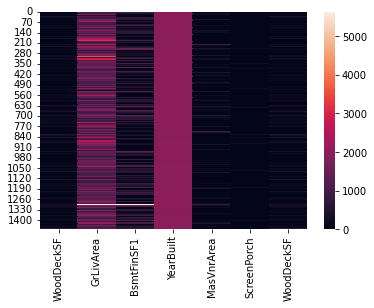

In [100]:
train = pd.concat([train_features['WoodDeckSF'],train_features['GrLivArea'], train_features['BsmtFinSF1'],
                 train_features['YearBuilt'],train_features['MasVnrArea'],train_features['ScreenPorch'] ,
                 train_features['WoodDeckSF'] ], axis=1)
sns.heatmap(train)

In [146]:
test = pd.concat([test_features['WoodDeckSF'],test_features['GrLivArea'], test_features['BsmtFinSF1'],
                 test_features['YearBuilt'],test_features['MasVnrArea'],test_features['ScreenPorch'] ,
                 test_features['WoodDeckSF'] ], axis=1)

In [85]:
print(train_features.shape,test_features.shape, train_labels.shape, test_labels.shape)

(1460, 64) (1459, 63) (1460,) (1459,)


In [102]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train))
print(normalizer.mean.numpy())

[[  94.24451  1515.4634    443.6397   1971.2676    103.68525    15.060957
    94.24451 ]]


In [103]:
first = np.array(train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   0. 1710.  706. 2003.  196.    0.    0.]]

Normalized: [[-0.75  0.37  0.58  1.05  0.51 -0.27 -0.75]]


In [64]:
linear_model = tf.keras.Sequential([ normalizer, tf.keras.layers.Dense(units=1) ])

linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 64)               129       
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 194
Trainable params: 65
Non-trainable params: 129
_________________________________________________________________


In [104]:
linear_model.predict(train)

array([[ -92.39913 ],
       [ 441.39252 ],
       [ -75.25871 ],
       ...,
       [ -21.311275],
       [ 583.5233  ],
       [1161.6375  ]], dtype=float32)

In [105]:
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history = linear_model.fit(train, train_labels, epochs=100, verbose=0, validation_split = 0.2)
    # Calculate validation results on 20% of the training data.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,116025.546875,119393.453125,95
96,115723.492188,119127.531250,96
97,115419.468750,118878.890625,97
98,115132.726562,118627.125000,98
99,114841.367188,118386.343750,99


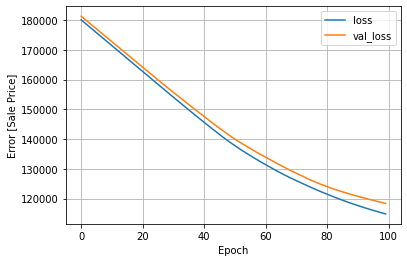

In [106]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Sale Price]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [110]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate( test, test_labels, verbose=0)
test_results

{'linear_model': 116656.078125}

In [111]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([ norm,
                               tf.keras.layers.Dense(64, activation='relu'),
                               tf.keras.layers.Dense(64, activation='relu'),
                               tf.keras.layers.Dense(1) ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 7)                15        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                512       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


In [114]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


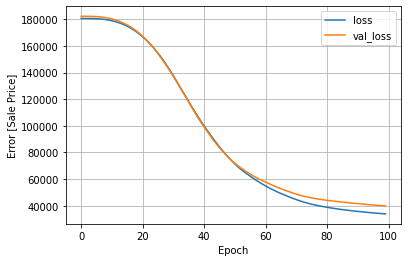

In [115]:
history = dnn_model.fit( train, train_labels, validation_split=0.2, verbose=0, epochs=100)

plot_loss(history)

In [117]:
test_results['dnn_model'] = dnn_model.evaluate(test, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [Price]']).T

,Mean absolute error [Price]
linear_model,116656.078125
dnn_model,59251.398438


In [121]:
test_predictions = dnn_model.predict(test)

In [140]:
test_predictions.flatten().shape

(1459,)

In [141]:
np.array(test_labels.round(2)).shape

(1459,)

In [142]:
df_pred_test = pd.DataFrame({'Actual Price':np.array(test_labels.round(2)),'Predicted Price':test_predictions.flatten()})
fig = px.line(df_pred_test, labels={'Actual Price':'Predicted Price'})

fig.show()

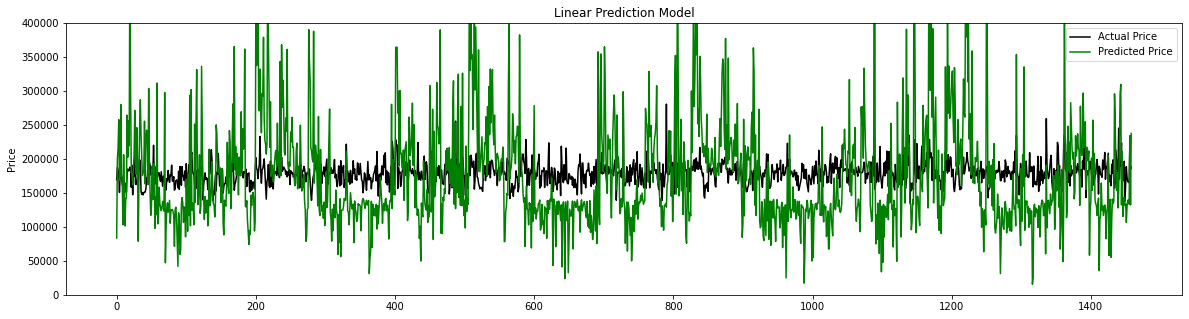

In [144]:
def plot(actual, predict, name):
  plt.figure(figsize=(20,5))
  plt.plot(actual,color='black',label='Actual Price')
  plt.plot(predict,color='green',label='Predicted Price')
  plt.title(f'{name}')
  plt.ylabel('Price')
  plt.ylim((0,400000))
  plt.legend(loc='upper right')
  plt.show()

plot(test_labels.round(2), test_predictions.flatten(), 'Linear Prediction Model')

In [168]:
train_featuress = train_features.drop(columns ='SalePrice')
train_featuress.shape

(1460, 63)

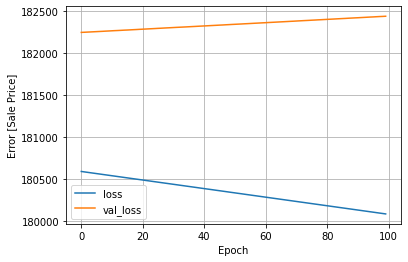

In [169]:
normalizer_all = tf.keras.layers.Normalization(axis=-1)
normalizer_all.adapt(np.array(train_featuress))

linear_model_all = tf.keras.Sequential([ normalizer_all, tf.keras.layers.Dense(units=1) ])
linear_model_all.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history_all = linear_model_all.fit(train_featuress, train_labels, epochs=100, verbose=0, validation_split = 0.2)

hist_all = pd.DataFrame(history_all.history)
hist_all['epoch'] = history_all.epoch
plot_loss(history_all)

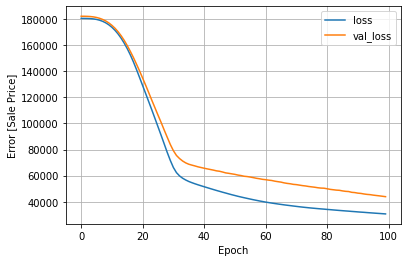

In [170]:
dnn_model_all = build_and_compile_model(normalizer_all)
history_annall = dnn_model_all.fit( train_featuress, train_labels, validation_split=0.2, verbose=0, epochs=100)

plot_loss(history_annall)

In [171]:
test_predictions_all = dnn_model_all.predict(test_features)

df_pred_test_all = pd.DataFrame({'Actual Price':np.array(test_labels.round(2)),'Predicted Price':test_predictions_all.flatten()})
fig = px.line(df_pred_test_all, labels={'Actual Price':'Predicted Price'})

fig.show()

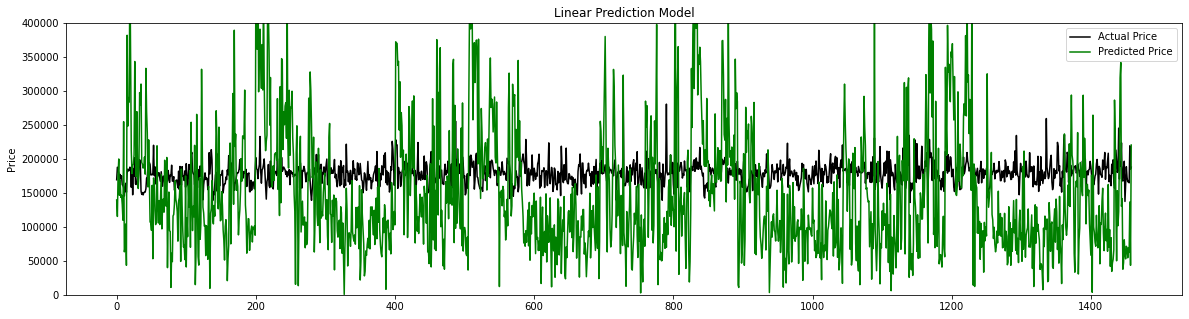

In [174]:
plot(test_labels.round(2), test_predictions_all.flatten(), 'Linear Prediction Model')

In [175]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(test, test_labels, verbose=0)
test_results['dnn_model'] = dnn_model.evaluate(test, test_labels, verbose=0)
test_results['linear_model_all'] = linear_model_all.evaluate(test_features, test_labels, verbose=0)
test_results['dnn_model_all'] = dnn_model_all.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [Price]']).T

,Mean absolute error [Price]
linear_model,116656.078125
dnn_model,59251.398438
linear_model_all,179899.671875
dnn_model_all,80203.375000
